In [1]:
# Uncomment and run the code below to run this notebook in Colab
#
# from os import chdir as cd
# ! git clone https://github.com/edsonportosilva/OptiCommPy-public
# cd('/content/OptiCommPy-public')
# !pip install .
# !pip install numba --upgrade

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from commpy.modulation import QAMModem

from optic.dsp import pulseShape, firFilter, decimate, symbolSync
from optic.models import phaseNoise, pdmCoherentReceiver
from optic.carrierRecovery import cpr
from optic.tx import simpleWDMTx
from optic.core import parameters
from optic.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power
from optic.plot import pconst

import scipy.constants as const
from numba import njit

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
%matplotlib inline
#figsize(7, 2.5)
figsize(10, 3)

In [5]:
%load_ext autoreload
%autoreload 2
#%load_ext line_profiler

In [6]:
@njit
def awgn(tx, noiseVar):
    
    σ        = np.sqrt(noiseVar)
    noise    = np.random.normal(0,σ, tx.shape) + 1j*np.random.normal(0,σ, tx.shape)
    noise    = 1/np.sqrt(2)*noise
    
    rx = tx + noise
    
    return rx

# Simulation of coherent transmission


## Transmitter

**Polarization multiplexed signal generation**

In [14]:
# Transmitter parameters:
paramTx = parameters()
paramTx.M   = 64           # order of the modulation format
paramTx.Rs  = 32e9         # symbol rate [baud]
paramTx.SpS = 8            # samples per symbol
paramTx.Nbits = 120000      # total number of bits per polarization
paramTx.pulse = 'rrc'      # pulse shaping filter
paramTx.Ntaps = 1024       # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01    # RRC rolloff
paramTx.Pch_dBm = 1        # power per WDM channel [dBm]
paramTx.Nch     = 1        # number of WDM channels
paramTx.Fc      = 193.1e12 # central optical frequency of the WDM spectrum
#paramTx.freqSpac = 37.5e9  # WDM grid spacing
paramTx.Nmodes = 2         # number of signal modes [2 for polarization multiplexed signals]

# generate WDM signal
sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

channel 0	 fc : 193.1000 THz
  mode #0	 power: -2.01 dBm
  mode #1	 power: -2.01 dBm
channel 0	 power: 1.00 dBm

total WDM signal power: 1.00 dBm


In [15]:
SNR = 18

SNRlin = 10**(SNR/10)/paramTx.SpS
noiseVar = signal_power(sigTx)/SNRlin

sigTx = awgn(sigTx, noiseVar)

###  coherent detection and demodulation

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 10.00 dBm, lw: 200.00 kHz, FO: 0.00 MHz



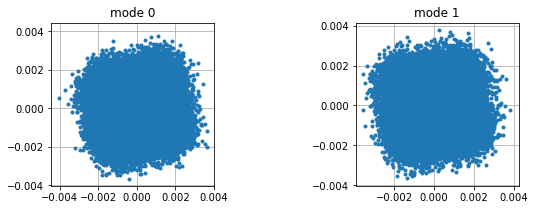

In [16]:
# Receiver

# parameters
chIndex  = 0     # index of the channel to be demodulated
plotPSD  = True

Fc = paramTx.Fc
Ts = 1/(paramTx.SpS*paramTx.Rs)

mod = QAMModem(m=paramTx.M)

freqGrid = paramTx.freqGrid
print('Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n'\
      %(chIndex, (Fc + freqGrid[chIndex])/1e12, const.c/(Fc + freqGrid[chIndex])/1e-9))

symbTx = symbTx_[:,:,chIndex]

# local oscillator (LO) parameters:
FO      = 0*64e6                # frequency offset
Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated
lw      = 200e3                 # linewidth
Plo_dBm = 10                    # power in dBm
Plo     = 10**(Plo_dBm/10)*1e-3 # power in W
ϕ_lo    = 0                     # initial phase in rad    

print('Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz\n'\
      %(Plo_dBm, lw/1e3, FO/1e6))

# generate LO field
π       = np.pi
t       = np.arange(0, len(sigTx))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigTx), Ts)
sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# polarization multiplexed coherent optical receiver
sigRx = pdmCoherentReceiver(sigTx, sigLO, θsig = 0, Rdx=1, Rdy=1)

# plot constellation
pconst(sigRx[0::paramTx.SpS,:])

### Matched filtering

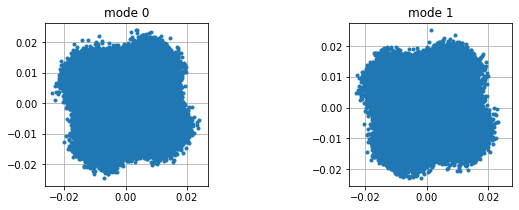

In [17]:
# Rx filtering

# Matched filtering
if paramTx.pulse == 'nrz':
    pulse = pulseShape('nrz', paramTx.SpS)
elif paramTx.pulse == 'rrc':
    pulse = pulseShape('rrc', paramTx.SpS, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1/paramTx.Rs)
    
pulse = pulse/np.max(np.abs(pulse))            
sigRx = firFilter(pulse, sigRx)

# plot constellation
pconst(sigRx[0::paramTx.SpS,:])

### Downsample to 1 sample/symbol and re-synchronization with transmitted sequences

In [18]:
# decimation
paramDec = parameters()
paramDec.SpS_in  = paramTx.SpS
paramDec.SpS_out = 1
sigRx = decimate(sigRx, paramDec)

d = symbolSync(sigRx, symbTx, 1)

# correct (possible) phase ambiguity w.r.t transmitted symbols
for k in range(sigRx.shape[1]):
    rot = np.mean(d[:,k]/sigRx[:,k])
    sigRx[:,k] = rot*sigRx[:,k]

# power normalization
sigRx = sigRx/np.sqrt(signal_power(sigRx))
d = d/np.sqrt(signal_power(d))

### Carrier phase recovery with blind phase search (BPS)

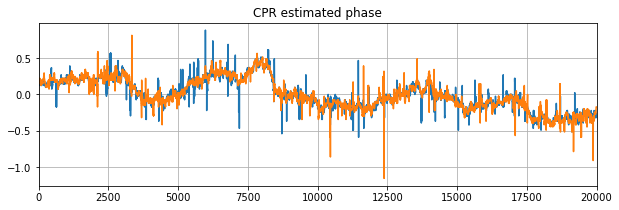

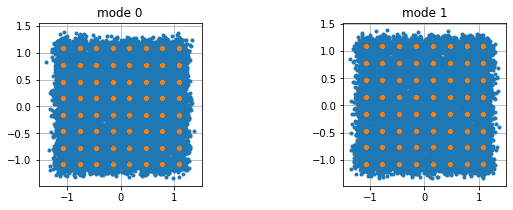

     pol.X     pol.Y      
SER: 1.77e-01, 1.83e-01
BER: 3.14e-02, 3.27e-02
SNR: 17.42 dB, 17.31 dB
MI: 5.25 bits, 5.22 bits
GMI: 5.26 bits, 5.22 bits


In [19]:
paramCPR = parameters()
paramCPR.alg = 'bps'
paramCPR.M   = paramTx.M
paramCPR.N   = 35
paramCPR.B   = 64
       
y_CPR, θ = cpr(sigRx, paramCPR=paramCPR)

y_CPR = y_CPR/np.sqrt(signal_power(y_CPR))

plt.figure()
plt.title('CPR estimated phase')
plt.plot(θ,'-')
plt.xlim(0, len(θ))
plt.grid();

discard = 1000

# plot constellations
pconst([y_CPR[discard:-discard,:],\
            d[discard:-discard,:]])

## Performance metrics

# correct (possible) phase ambiguity
for k in range(y_CPR.shape[1]):
    rot = np.mean(d[:,k]/y_CPR[:,k])
    y_CPR[:,k] = rot*y_CPR[:,k]

y_CPR = y_CPR/np.sqrt(signal_power(y_CPR))

ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind,:], d[ind,:], mod)
GMI,_    = monteCarloGMI(y_CPR[ind,:], d[ind,:], mod)
MI       = monteCarloMI(y_CPR[ind,:], d[ind,:], mod)

print('     pol.X     pol.Y      ')
print('SER: %.2e, %.2e'%(SER[0], SER[1]))
print('BER: %.2e, %.2e'%(BER[0], BER[1]))
print('SNR: %.2f dB, %.2f dB'%(SNR[0], SNR[1]))
print('MI: %.2f bits, %.2f bits'%(MI[0], MI[1]))
print('GMI: %.2f bits, %.2f bits'%(GMI[0], GMI[1]))

### Carrier phase recovery with decision-directed phase-locked loop (DDPLL)

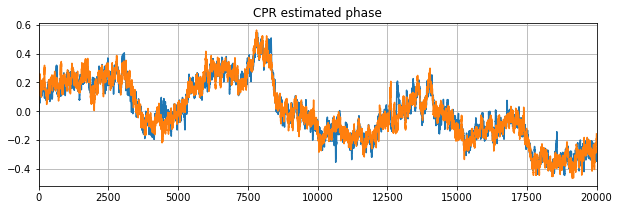

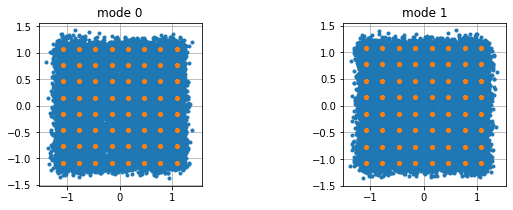

     pol.X     pol.Y      
SER: 1.80e-01, 1.81e-01
BER: 3.15e-02, 3.17e-02
SNR: 17.41 dB, 17.45 dB
MI: 5.30 bits, 5.30 bits
GMI: 5.31 bits, 5.30 bits


In [20]:
paramCPR = parameters()
paramCPR.alg = 'ddpll'
paramCPR.M   = paramTx.M
paramCPR.tau1 = 1/(2*np.pi*10e3)
paramCPR.tau2 = 1/(2*np.pi*10e3)
paramCPR.Kv  = 0.15
paramCPR.pilotInd = np.arange(0, len(sigRx), 25)

y_CPR, θ = cpr(sigRx, symbTx=d, paramCPR=paramCPR)

y_CPR = y_CPR/np.sqrt(signal_power(y_CPR))

plt.figure()
plt.title('CPR estimated phase')
plt.plot(θ,'-')
plt.xlim(0, len(θ))
plt.grid();

discard = 1000

# plot constellations
pconst([y_CPR[discard:-discard,:],\
            d[discard:-discard,:]])

## Performance metrics

# correct (possible) phase ambiguity after CPR
for k in range(y_CPR.shape[1]):
    rot = np.mean(d[:,k]/y_CPR[:,k])
    y_CPR[:,k] = rot*y_CPR[:,k]

y_CPR = y_CPR/np.sqrt(signal_power(y_CPR))

ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind,:], d[ind,:], mod)
GMI,_    = monteCarloGMI(y_CPR[ind,:], d[ind,:], mod)
MI       = monteCarloMI(y_CPR[ind,:], d[ind,:], mod)

print('     pol.X     pol.Y      ')
print('SER: %.2e, %.2e'%(SER[0], SER[1]))
print('BER: %.2e, %.2e'%(BER[0], BER[1]))
print('SNR: %.2f dB, %.2f dB'%(SNR[0], SNR[1]))
print('MI: %.2f bits, %.2f bits'%(MI[0], MI[1]))
print('GMI: %.2f bits, %.2f bits'%(GMI[0], GMI[1]))